In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import aplpy
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy.io import fits
import astropy.coordinates as coord
from astropy.wcs import WCS
import matplotlib.patheffects as PE
import brewer2mpl
set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors
dark2 = brewer2mpl.get_map('Dark2', 'qualitative', 8).mpl_colors
import prettyplotlib as ppl
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib import rc
from cycler import cycler
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)
rc('axes', prop_cycle=cycler('color', set2))

In [2]:
fitsfile = '../../ocen_images/Omega_Cen_Ks.fits'
with fits.open(fitsfile) as hdu:
    wcs2 = WCS(hdu[0].header)
    dat = hdu[0].data

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


In [3]:
blerp = pd.read_csv('Kaluzny2004rrl.txt', usecols=[0,1,2,4], delim_whitespace=True)
crowd = pd.read_csv('reject.csv')

rej = blerp[blerp.id.isin(crowd.reject)]

rejab = rej[rej.type == 0]
rejc = rej[rej.type == 1]

typeab = blerp[blerp.type == 0]
typec = blerp[blerp.type == 1]

def get_x_y(df):
    ra1 = coord.Angle(df.ra, unit='hour')
    abra = ra1.degree
    dec1 = coord.Angle(df.dec, unit='deg')
    abdec = dec1.degree
    #x1, y1 = wcs2.all_world2pix(abra, abdec, 1)
    return abra, abdec

x1, y1 = get_x_y(typeab)
x2, y2 = get_x_y(typec)
x3, y3 = get_x_y(rejab)
x4, y4 = get_x_y(rejc)

In [4]:
xcenter = np.mean([2200,dat.shape[1]-1100])
ycenter = np.mean([700,dat.shape[0]-100])
ra1, dec1 = wcs2.all_pix2world(2200, 700, 1)
ra2, dec2 = wcs2.all_pix2world(dat.shape[1]-1100, dat.shape[0]-100, 1)
print ra1, dec1, ra2, dec2
ra_center, dec_center = wcs2.all_pix2world(xcenter, ycenter, 1)
width = np.abs(ra2 - ra1)
height = np.abs(dec2 - dec1)
print width / 1.5, height

202.143487346 -47.7165919987 201.213111377 -47.2148665044
0.620250645852 0.501725494364


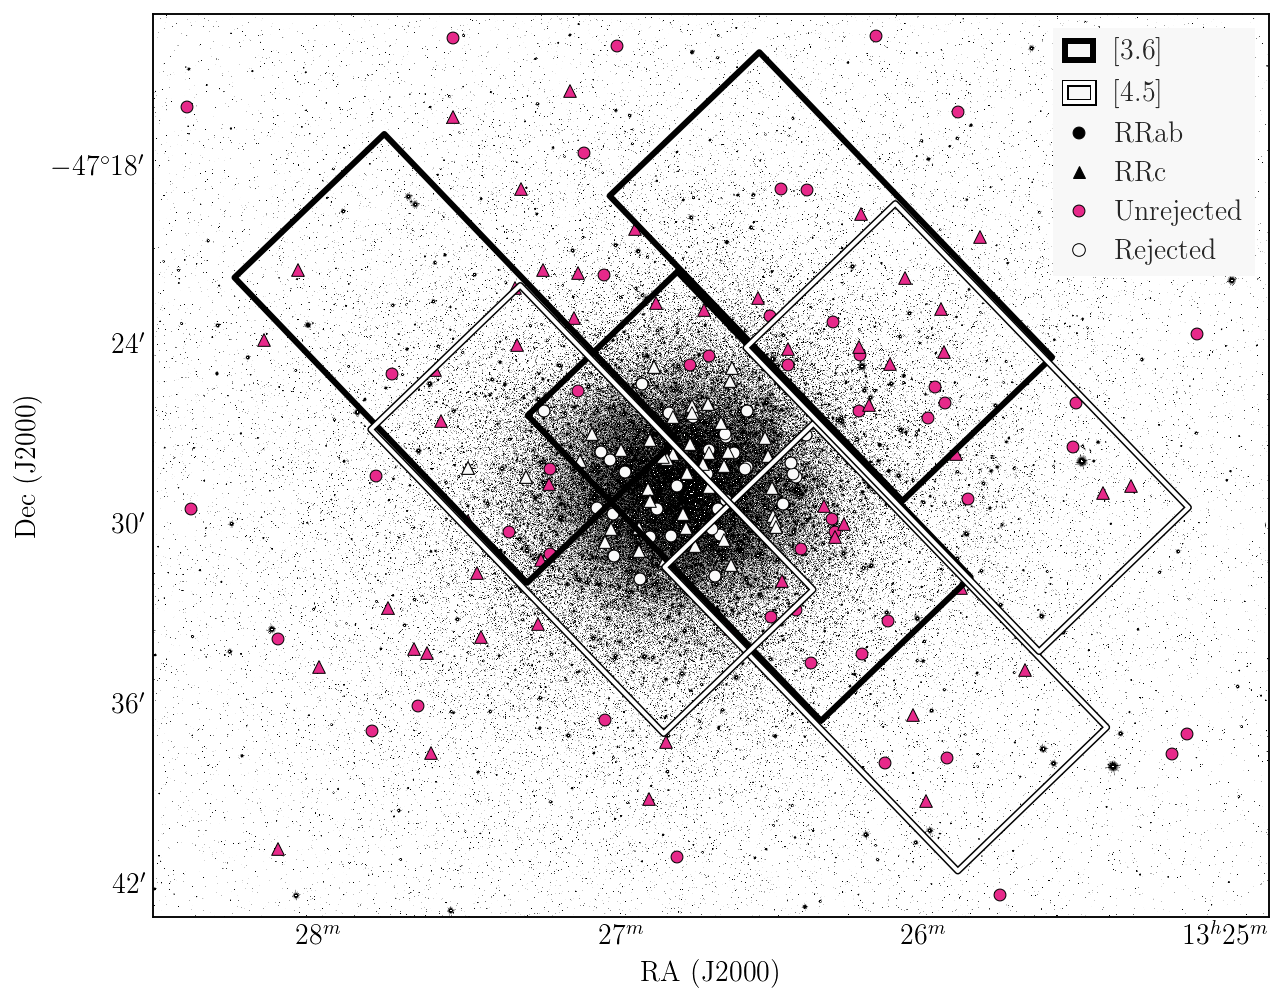

In [15]:
#fig = plt.figure(figsize=(9,8))
ax = aplpy.FITSFigure(fitsfile)
ax.show_grayscale(vmin=10**2,vmax=10**3,stretch='log')
ax.set_theme('publication')
ax.ticks.hide()
ax.tick_labels.set_yformat('dd:mm')
ax.tick_labels.set_xformat('hh:mm')
ax.recenter(ra_center, dec_center, width=width/1.5, height=height)
ax.frame.set_linewidth(0.75)

for i in glob.glob('../../ocen_images/omegaCen_*.fits'):
    mapnum = int(i.split('_')[2])
    filt = i.split('_')[5].split('.')[0]
    with fits.open(i) as f:
        instrument_wcs = WCS(f[0].header)
        yshape = f[0].data.shape[0]
        xshape = f[0].data.shape[1]
    vertices = instrument_wcs.calc_footprint().T
    if filt == '3p6um':
        if mapnum == 1:
            ax.show_polygons([vertices], linewidth = 3, facecolor='none',
                             edgecolor='k', label = '$3.6\ \mu$m', zorder = 5-mapnum)
        else:
            ax.show_polygons([vertices], linewidth = 3, facecolor='none',
                             edgecolor='k', zorder = 5-mapnum)
    if filt == '4p5um':
        if mapnum == 1:
            ax.show_polygons([vertices], linewidth = 2, facecolor='none',
                             edgecolor='w', label = '$4.5\ \mu$m', zorder = 5-mapnum,
                             path_effects=[PE.withStroke(linewidth=3.5, foreground='k')])
        else:
            ax.show_polygons([vertices], linewidth = 2, facecolor='none',
                             edgecolor='w', zorder = 5-mapnum,
                             path_effects=[PE.withStroke(linewidth=3.5, foreground='k')])
ax.show_markers(x1, y1, s=35., alpha=1, facecolor=dark2[3], linewidth=0.5, 
                label='Unrejected', rasterized=True, edgecolor='k')
ax.show_markers(x2, y2, s=40., marker='^', alpha=1, facecolor=dark2[3], linewidth=0.5, 
                rasterized=True, edgecolor='k')
ax.show_markers(x3, y3, s=35., alpha=1, facecolor='#FAFAFA', linewidth=0.5, 
                label='Rejected', rasterized=True, edgecolor='k')
ax.show_markers(x4, y4, s=40., marker='^', alpha=1, facecolor='#FAFAFA', linewidth=0.5, 
                rasterized=True, edgecolor='k')

patch1 = patches.Rectangle([0, 0], 1, 1, linewidth = 3, facecolor='none',
                           edgecolor='k')
patch2 = patches.Rectangle([0, 0], 1, 1, linewidth = 2, facecolor='none',
                             edgecolor='w',
                             path_effects=[PE.withStroke(linewidth=3.5, foreground='k')])
rrab = lines.Line2D([], [], marker='o', markersize=np.sqrt(35.), alpha=1, color='k', lw=0)
rrc = lines.Line2D([], [], marker='^', markersize=np.sqrt(40.), alpha=1, color='k', lw=0)
unrej = lines.Line2D([], [], marker='o', markersize=np.sqrt(35.), alpha=1, color=dark2[3], lw=0)
rej = lines.Line2D([], [], marker='o', markersize=np.sqrt(40.), alpha=1, color='#FAFAFA', lw=0)

#handles0, labels0 = ax.get_legend_handles_labels()
handles = [patch1, patch2, rrab, rrc, unrej, rej]
labels = ['[3.6]', '[4.5]', 'RRab', 'RRc', 'Unrejected', 'Rejected']

ppl.legend(handles=handles, labels=labels, loc=1, prop={'size':14}, handlelength=1, numpoints=1)


ax.save('final_plots/omegacen_coverage_map_new.pdf', dpi=400)